In [1]:
import sys
import os
import ctypes


# Get the absolute path of the utils directory
utils_path = os.path.abspath("lib")
sys.path.append(utils_path)
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import qiskit.qpy as qpy
import pickle
import json
import matplotlib.patches as mpatches
from numba import njit
from numba.typed import List
from plotting import *
from readings import *
from tile_process import *

In [2]:
def count_gates(excitations, N):
    count_lst = []
    for excitation in excitations:
        a, i = excitation
        if len(a) == 1:
            if a == i:
                print("single evolution")
            else:
                # print("single hopping")
                cur_count = count_single_CNOT(a[0],i[0],N)
                count_lst.extend(cur_count)
        if len(a) == 2:
            a.sort()
            i.sort()
            p,q = a
            k,m = i
            if set(a) & set(i) != set():
                # print("controlled hopping")
                j = list(set(a) & set(i))
                j = j[0]
                p,q = list(set(a) ^ set(i))
                cur_count = count_controlled_CNOT(p, j, q, N)
                count_lst.extend(cur_count)
            else:
                # print("double hopping")
                cur_count = count_double_CNOT(p,q,k,m,N)
                count_lst.extend(cur_count)
                # print("excitation", p,q,k,m)
                # print(cur_count)
    return count_lst

In [3]:
import matplotlib.cm as cm
N = 24
def plot_excitation(distance, norm, excitations, normalized = True, reordered=True):
    # x: the color parameter
    colormap = plt.cm.viridis

    if reordered:
        excitations = orbital_reordering(excitations, f_orbs)
    print(excitations)
    count_lst = count_gates(excitations, N)
    total_CNOT = 0
    for count in count_lst:
        total_CNOT += count[1]
    tunneling_CNOT = np.zeros(N)
    tunneling_dist = np.zeros(N)
    for n in range(1,N):
        for CNOT in count_lst:
            src, tar = CNOT[0]
            count = CNOT[1]
            if src < n and tar >= n:
                tunneling_CNOT[n] += count
                tunneling_dist[n] += (tar-src)*count
                if distance == 0:
                    distance = 1e-16
    
    print(total_CNOT)
    print(tunneling_CNOT)
    
    if normalized:
        for i in range(len(tunneling_CNOT)):
            tunneling_CNOT[i] /= total_CNOT
    if not reordered:
        plt.plot(np.arange(1,N), tunneling_CNOT[1:], label = f"distance = {distance}({parameter})", color = colormap(norm((distance))))
    else:
        plt.plot(np.arange(1,N), tunneling_CNOT[1:], label = f"cluster seperation = {1+distance}$d_0$", color = colormap(norm((distance))))


Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH
[[array([2, 0], dtype=uint8), array([6, 0], dtype=uint8)], [array([2, 0], dtype=uint8), array([4, 2], dtype=uint8)], [array([2, 0], dtype=uint8), array([6, 1], dtype=uint8)], [array([2, 0], dtype=uint8), array([4, 3], dtype=uint8)], [array([2, 0], dtype=uint8), array([7, 1], dtype=uint8)], [array([2, 0], dtype=uint8), array([5, 3], dtype=uint8)], [array([2, 0], dtype=uint8), array([7, 5], dtype=uint8)], [array([1, 0], dtype=uint8), array([4, 1], dtype=uint8)], [array([3, 0], dtype=uint8), array([4, 3], dtype=uint8)], [array([1, 2], dtype=uint8), array([6, 1], dtype=uint8)], [array([3, 2], dtype=uint8), array([6, 3], dtype=uint8)], [array([1, 0], dtype=uint8), array([5, 0], dtype=uint8)], [array([3, 0], dtype=uint8), array([7, 0], dtype=uint8)], [array([1, 2], dtype=uint8), array([5, 2], dtype=uint8)], [array([3, 2], dtype=uint8), array([7, 2], dtype=uint8)], [array([3, 1], dtype=uint8), array([6, 0], dtyp

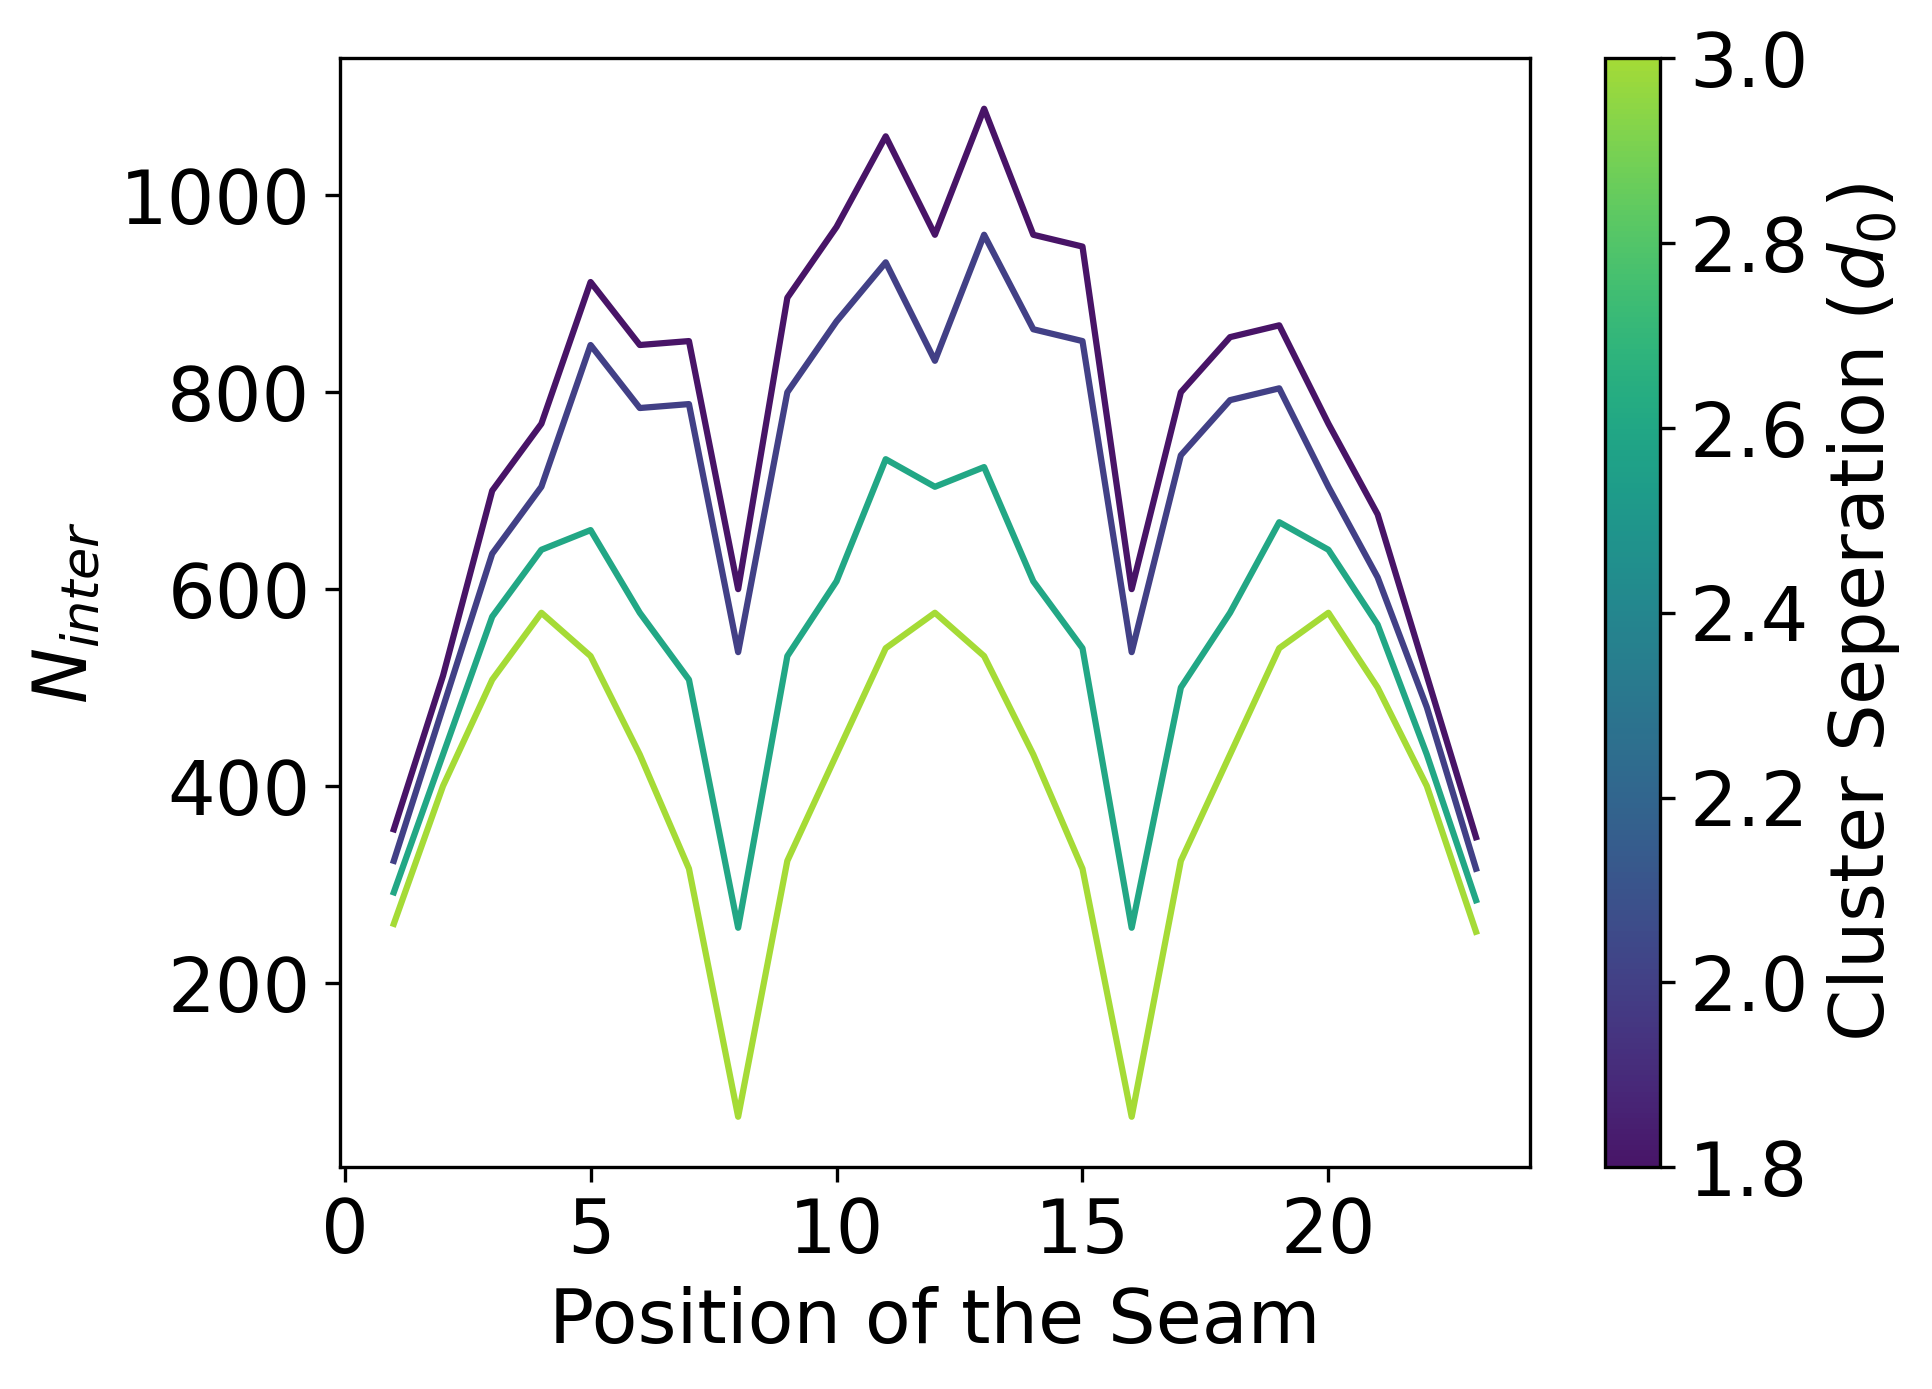

In [16]:

prehead = "../H_12_cluster/"
read_epsilon = 1.0
epsilon = 0.001
seam_lst = [8,16]
f_orbs = (2,2,2,2,2,2)
N = 24


fig, ax = plt.subplots(dpi=300)
distance_lst = [0.8, 1.0, 1.6, 2.0]
norm = plt.Normalize(min(distance_lst)*0.9+1, max(distance_lst)*1.1+1)
for i in range(len(distance_lst)):
    distance = distance_lst[i]
    uop, all_g = read_uop(distance, read_epsilon, prehead)
    excitations = create_excitation(uop, all_g, epsilon)
    # excitations = orbital_reordering(excitations, f_orbs)
    x = i/len(distance_lst)
    plot_excitation(distance+1, norm, excitations, normalized=False)
    # plot_excitation(distance, f_orbs, normalized=normalized, reordered=False)
# plt.legend()
# plt.plot(np.arange(1,N), tunneling_dist[1:])
plt.xlabel("Position of the Seam")
plt.ylabel(r"$N_{inter}$")

# plt.legend(["tunneling CNOT number", "tunneling CNOT distance"])
# %%
plt.rcParams.update({'font.size': 18})  # Update font size
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array to avoid warnings
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'Cluster Seperation ($d_0$)')
cbar.ax.set_ylim(min(distance_lst) + 1, max(distance_lst) + 1)  # Set colorbar limits
# plt.title(r"$\epsilon = 0.001$")
plt.show()

In [5]:
prehead = "../H_12_cluster/"
distance = 0.9
distance = float(distance)
read_epsilon = 1.0
epsilon = 0.0093260334688322
seam_lst = [8,16]
f_orbs = (2,2,2,2,2,2)
N = 24
ratio = 8
uop, all_g = read_uop(distance, read_epsilon, prehead)
epsilon_lst = np.linspace(0.1,3,100)
epsilon_lst = 10**-(epsilon_lst)
print(all_g)


excitations = create_excitation(uop, all_g, epsilon)
print(len(excitations))
excitations = orbital_reordering(excitations, f_orbs)

Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH
[[-6.390559066268979e-07, 0], [-6.390559066235961e-07, 1], [3.612505071105087e-05, 2], [3.612505071105002e-05, 3], [-3.5916604293906526e-05, 4], [-3.591660429390624e-05, 5], [6.88957109969424e-07, 6], [6.889571099690394e-07, 7], [1.0267349969341769e-08, 8], [1.0267349969448548e-08, 9], [2.597499058296072e-06, 10], [2.5974990582961404e-06, 11], [4.354828233533266e-08, 12], [4.354828233556771e-08, 13], [1.0472887388278347e-06, 14], [1.0472887388279895e-06, 15], [-1.0331160171210275e-06, 16], [-1.0331160171208583e-06, 17], [-5.788275842657716e-08, 18], [-5.788275842657802e-08, 19], [-1.029015323687592e-06, 20], [-1.0290153236880218e-06, 21], [-4.637878152801783e-08, 22], [-4.637878152834001e-08, 23], [-7.854019638092936e-09, 24], [-7.85401963809422e-09, 25], [1.5786687610847074e-06, 26], [1.578668761084698e-06, 27], [-3.5382528536896692e-09, 28], [-3.5382528535796013e-09, 29], [1.075038721049903e-06, 30], [1

In [6]:
single_count, controlled_count, double_count = CNOT_histogram(excitations, N)
inter_gate = (single_count+controlled_count+double_count)
plt.plot(inter_gate)

NameError: name 'CNOT_histogram' is not defined